In [1]:
import pandas as pd 

In [2]:
df = pd.read_csv('data/movie_db.csv')

## Process Genre Tags

In [131]:
genre = df['genre'].tolist()

def get_genres(genre):
    genre_set = []

    for i in genre:
        genres = i.split(',')
        for g in genres:

            g = g.strip()

            if g not in genre_set:
                genre_set.append(g)

        idx2genre = dict(enumerate(genre_set))
        genre2idx = {g : idx for idx, g in idx2genre.items()}
    
    return idx2genre, genre2idx

In [132]:
idx2genre, genre2idx = get_genres(genre)

In [136]:
def count_genre(genre, genre2idx):
    
    genre_counts = {genre : 0 for genre in genre2idx.keys()}
    
    for i in genre:
        genres = i.split(',')
        for g in genres:

            g = g.strip()
            
            genre_counts[g] += 1
            
    return genre_counts

In [137]:
genre_counts = count_genre(genre, genre2idx)

In [143]:
def encode_genres(genre, genre2idx):
    
    encoded = []
    
    for genres in genre:
        
        genres = genres.split(',')
        encoded_genre = torch.LongTensor([genre2idx[g.strip()] for g in genres])
        encoded.append(encoded_genre)
        
    return encoded

In [144]:
encoded_genres = encode_genres(genre, genre2idx)

## Process Plot and Build Vocab

In [7]:
import re
from tqdm.notebook import tqdm

In [8]:
plots = df['plot']

In [9]:
def reg_remove(plot):
    remove_non_words = re.compile(r'[^\w -]')
    clean = re.sub(remove_non_words, '', plot)
    return clean


In [198]:
def build_vocab(plots):
    
    vocab = {}
    processed_plots = []
    
    for plot in tqdm(plots):

        plot = reg_remove(plot.lower()).split(' ')
        plot.insert(0, '<start>')
        plot.append('<end>')
        
        for token in plot:

            if token not in vocab:
                vocab[token] = len(vocab) +1 
        
        processed_plots.append(plot)
        
    idx2wrd = {idx : wrd for wrd,idx in vocab.items()}
    
    return vocab, idx2wrd, processed_plots
    


In [199]:
wrd2idx, idx2wrd, processed_plots = build_vocab(plots)

  0%|          | 0/499 [00:00<?, ?it/s]

In [200]:
idx2wrd

{1: '<start>',
 2: 'a',
 3: 'little',
 4: 'boy',
 5: 'named',
 6: 'andy',
 7: 'loves',
 8: 'to',
 9: 'be',
 10: 'in',
 11: 'his',
 12: 'room',
 13: 'playing',
 14: 'with',
 15: 'toys',
 16: 'especially',
 17: 'doll',
 18: 'woody',
 19: 'but',
 20: 'what',
 21: 'do',
 22: 'the',
 23: 'when',
 24: 'is',
 25: 'not',
 26: 'them',
 27: 'they',
 28: 'come',
 29: 'life',
 30: 'believes',
 31: 'that',
 32: 'he',
 33: 'has',
 34: 'as',
 35: 'toy',
 36: 'good',
 37: 'however',
 38: 'must',
 39: 'worry',
 40: 'about',
 41: 'andys',
 42: 'family',
 43: 'moving',
 44: 'and',
 45: 'does',
 46: 'know',
 47: 'birthday',
 48: 'party',
 49: 'realize',
 50: 'mother',
 51: 'gave',
 52: 'him',
 53: 'an',
 54: 'action',
 55: 'figure',
 56: 'known',
 57: 'buzz',
 58: 'lightyear',
 59: 'who',
 60: 'believe',
 61: 'quickly',
 62: 'becomes',
 63: 'new',
 64: 'favorite',
 65: 'now',
 66: 'consumed',
 67: 'jealousy',
 68: 'tries',
 69: 'get',
 70: 'rid',
 71: 'of',
 72: 'then',
 73: 'both',
 74: 'are',
 75: 'lost

In [102]:
from torch.nn.utils.rnn import pad_sequence

In [94]:
def encode(wrd2idx, plot):
    
    encoded_plot = []
    
    for token in plot:
        
        if token in wrd2idx:
            encoded_plot.append(wrd2idx[token])
            
        else:
            encoded_plot.append(len(wrd2idx)+1)
            
    return encoded_plot

In [105]:
def encode_plots(plots, wrd2idx):
    
    encoded = []
    
    for i in tqdm(plots):
        encoded.append(torch.LongTensor(encode(wrd2idx, i)))
        
    return pad_sequence(encoded,batch_first=True)

In [106]:
encoded = encode_plots(processed_plots, wrd2idx)

  0%|          | 0/499 [00:00<?, ?it/s]

## Process Images

In [64]:
import os
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
import torch
preprocess = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(448),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [65]:
def process_image(filename):
    
    input_image = Image.open(filename)
    processed = preprocess(input_image)
    
    return processed

In [66]:
poster_dir = 'data/posters'

In [67]:
processed_images = []
for i in tqdm(sorted(os.listdir(poster_dir), key=lambda x:int(x.split('-')[0]))):
    filename = '{}/{}'.format(poster_dir, i)
    image_id = i.split('-')[0]
    processed_img = process_image(filename)
    
    processed_images.append(processed_img)


  0%|          | 0/499 [00:00<?, ?it/s]

In [109]:
processed = torch.stack(processed_images)

In [160]:
film_ids = [i[13:-5] for i in df['poster_path'].tolist()]

In [150]:
from torch.utils.data import Dataset, DataLoader

In [169]:
class film_dataset(Dataset):
    
    def __init__(self, film_id, plot, poster, genre):
        
        self.film_id = film_id
        self.plot = plot
        self.poster = poster
        self.genre = genre
        
    def __getitem__(self, idx):
        
        return {
            'film_id' : self.film_id[idx],
            'plot'    : self.plot[idx],
            'poster'  : self.poster[idx],
            'genre'   : self.genre[idx]
        }
        
    def __len__(sef):
        return len(film_id)

In [170]:
dataset = film_dataset(film_ids, encoded, processed, encoded_genres)

In [210]:
dataset[10]

{'film_id': '11-the-american-president',
 'plot': tensor([  1, 475, 476,  24, 477,  22, 478,  71,  11, 479, 480,  34, 416,  71,
          22, 417, 418, 481,   2, 482,  14,   2, 383, 220,  44,  33, 483,   8,
           9, 484,  14,  22, 485,  11, 486, 487, 488,  31,  24, 365,  32, 489,
         490, 491, 492,   2, 493, 494, 495, 496,  97,  53, 497, 498, 499, 481,
         500, 501,  14, 473,  44,  91, 408, 502, 503,  27, 504, 505,   8, 407,
         115,   2, 506, 507, 508,   8,   9,   2, 509, 510,  97,  22, 511, 416,
          71, 512,  11, 513,  14, 492, 514,  22, 515,  97,  11, 516, 494, 517,
         518, 519, 520,   8, 521,  53, 522, 115,  22, 523, 524, 164,  32, 525,
          25,  21,  10,  22, 526, 486,  34, 527, 221, 528, 166, 529, 530,  90,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
   

## Decode 

In [213]:
def decode_plot(idx2wrd, plot):
    
    plot = [int(i) for i in list(plot)]
    decoded = [idx2wrd[i] for i in plot if i != 0]
    
    return ' '.join(decoded[1:-1])

In [218]:
def decode_genre(genre, idx2genre):
    
    genre = [int(i) for i in list(genre)]
    decoded = [idx2genre[i] for i in genre]
    return decoded

In [219]:
decode_genre(dataset[1]['genre'], idx2genre)

['Adventure', 'Comedy', 'Family', 'Fantasy']

In [220]:
from torchvision.transforms import ToPILImage

In [251]:
def view_image(image):
    invTrans = transforms.Compose([
                                transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                                                     std=[1/0.229, 1/0.224, 1/0.225]),
                               ])
    pil_image = ToPILImage()(invTrans(image))
    return pil_image


In [254]:
image = view_image(dataset[23]['poster'])

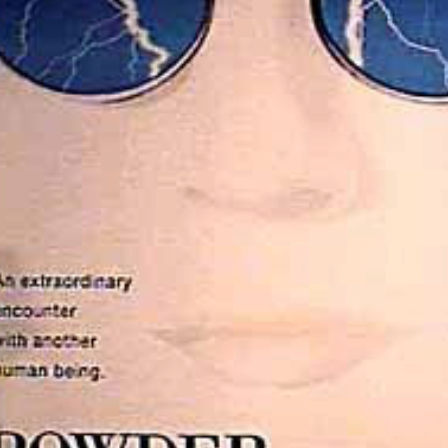

In [255]:
image